# Exploring the Relationship Between World Happiness and the BigMac Index
Kyle Pelham (kpelham@calpoly.edu)


**February 2023**


## Introduction

In this notebook, we are exploring the correlation of a country's Big Mac Index to its overall happiness.

The Big Mac index is an economic measurement of consumer purchasing power by comparing the price of a single Big Mac in other countries to the cost of a Big Mac in the United States. The Purchasing Power Parity(PPP) theory suggests that a product or good will cost the same across all countries after converting to their local currency. However, this is an ideal situation and in reality there are currencies that are overvalued(they pay more in USD) and undervalued(they pay less in USD). The Big Mac Index is fun way to get an approximate measurement of global buying power since the Big Mac is a common item that is sold across over 150+ countries and is essentially made the same way.

### Hypothesis:

**Null:** There is no correlation between a country's Big Mac Index and its overall happiness.

**Alternative:** There is a correlation between a country's Big Mac Index and its overall happiness.



#### **The data used to complete this analysis can be found below:**

Big Max Index Data (using adjusted index): [https://github.com/TheEconomist/big-mac-data](https://github.com/TheEconomist/big-mac-data)

World Happiness Report: [https://worldhappiness.report/archive/](https://worldhappiness.report/archive/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

## Reading in the Data

To perform this analysis, Big Mac Data must be joined onto the Happiness data. First, the happiness data for each year needs to be merged together, however,  the countries listed in each year's happiness report slightly vary from year to year. To fix this, each year's data is filtered on a common list of countries across all eight years and then is merged by stacking the rows for each.

In [2]:
# Read in World Happiness data for each year
happy2015 = pd.read_csv('Data/2015.csv')
happy2016 = pd.read_csv('Data/2016.csv')
happy2017 = pd.read_csv('Data/2017.csv')
happy2018 = pd.read_csv('Data/2018.csv')
happy2019 = pd.read_csv('Data/2019.csv')
happy2020 = pd.read_csv('Data/2020.csv')
happy2021 = pd.read_csv('Data/2021.csv')
happy2022 = pd.read_csv('Data/2022.csv')


In [3]:
# Create Year column for each dataset
happy2015['Year'] = '2015'
happy2016['Year'] = '2016'
happy2017['Year'] = '2017'
happy2018['Year'] = '2018'
happy2019['Year'] = '2019'
happy2020['Year'] = '2020'
happy2021['Year'] = '2021'
happy2022['Year'] = '2022'

# Create a list of each df for later iteration
happiness_data = [happy2015,happy2016,happy2017,happy2018,happy2019,happy2020,happy2021,happy2022]

In [4]:
# Required columns for subsetting
columns_to_keep = ['Country', 'Happiness Score', 'Year']

# Create an empty list to store the extracted dataframes
happiness_data_reduced = []

# loop over each dataframe in happiness_data
for df in happiness_data:
    # extract the desired columns and assign it back to the same dataframe
    df = df[columns_to_keep]
    # append the modified dataframe to the happiness_data_reduced list
    happiness_data_reduced.append(df)

In [5]:
# Get the set of countries in each dataframe
country_sets = [set(df['Country']) for df in happiness_data_reduced]

# Find the intersection of all the sets
common_countries = set.intersection(*country_sets)

# Filter each dataframe to include only the common countries
filtered_dfs = [df[df['Country'].isin(common_countries)] for df in happiness_data_reduced]

# Bind rows of each happiness dataset together
final_happiness = pd.concat(filtered_dfs)
final_happiness['Happiness Score'] = pd.to_numeric(final_happiness['Happiness Score'])
final_happiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 145
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          936 non-null    object 
 1   Happiness Score  936 non-null    float64
 2   Year             936 non-null    object 
dtypes: float64(1), object(2)
memory usage: 29.2+ KB


The Big Mac Index data is merged with the happiness data by performing an inner join on Country and Year. All data before 2015 is dropped to match up with the happiness data. Uncommon countries were looked at externally for misspellings but there were none. The final dataset is much smaller than the original happiness dataset since the Big Mac Index data only has 56 countries, but this should be enough to perform the analysis.

In [6]:
bigmac = pd.read_csv('Data/big-mac-adjusted-index.csv')

bigmac = bigmac[bigmac['date'].str.contains('01-01')]

# separate the date column into year and month and filter where year is greater than 2015. 
bigmac["year"] = bigmac["date"].str.split("-").str.get(0)
bigmac["month"] = bigmac["date"].str.split("-").str.get(1)
bigmac["Country"] = bigmac["name"]
bigmac = bigmac[bigmac["year"]>="2015"]

# Drop the date column
bigmac.drop("date", axis=1, inplace=True)
bigmac.drop("month", axis=1, inplace=True)
bigmac.drop("name", axis=1, inplace=True)

# concatenate name and year in a new column
bigmac["Country_Year"] = bigmac["Country"] + " " + bigmac["year"]
#print(bigmac)

# convert the year column to string
final_happiness["Year"] = final_happiness["Year"].astype(str)
final_happiness["Country_Year"] = final_happiness["Country"] + " " + final_happiness["Year"]

# Join the datasets on key column
merged = pd.merge(bigmac, final_happiness, on='Country_Year', how='inner', suffixes=('_1', '_2'))
#print(merged)

# Select rows needed for analysis
merged2 = merged[['USD', 'Country_1','Happiness Score','Year']]

# Rename USD to proper name
merged2 = merged2.rename({'USD': 'BigMacIndex(USD)'}, axis=1)

merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BigMacIndex(USD)  250 non-null    float64
 1   Country_1         250 non-null    object 
 2   Happiness Score   250 non-null    float64
 3   Year              250 non-null    object 
dtypes: float64(2), object(2)
memory usage: 9.8+ KB


# Analyzing the Data

## Plotting Histograms of Big Mac Index and Happiness Score

The first step in analyzing the data is to plot histograms of the Big Mac Index and Happiness Score to get a sense of the distribution of the data. The Big Mac Index is slighlty skewed to the right and the Happiness Score with a very fat right tail. The Big Mac Index is skewed to the right because there are more countries with a lower Big Mac Index than countries with a higher Big Mac Index. The Happiness Score is has a fat right tail because there are more countries with above average Happiness Score within our sample.

[Text(0.5, 1.0, 'Big Mac Index')]

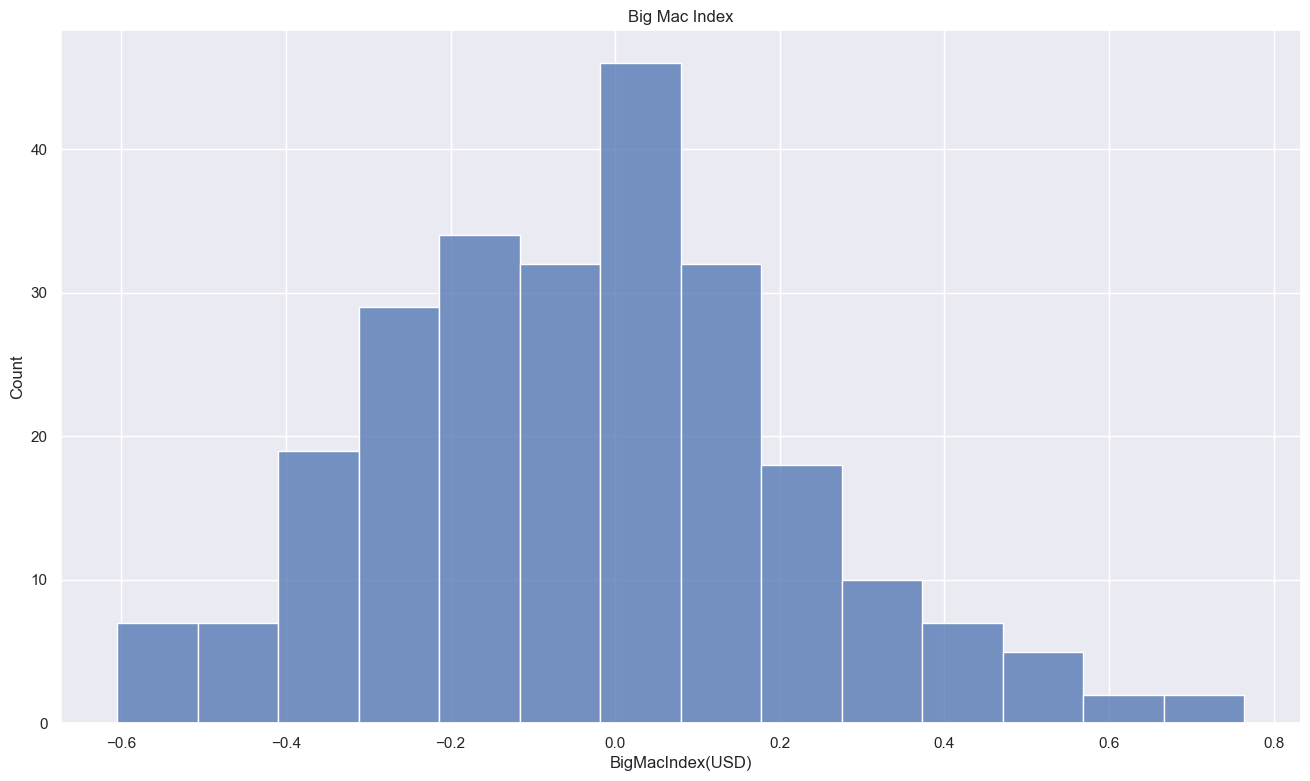

In [7]:
# Box plot for Big Mac Index by year. Each observation is one country
sns.set(rc={'figure.figsize':(16,9)})
sns.histplot(x="BigMacIndex(USD)", data=merged2, bins = 'auto').set(title='Big Mac Index')

[Text(0.5, 1.0, 'Happiness Score')]

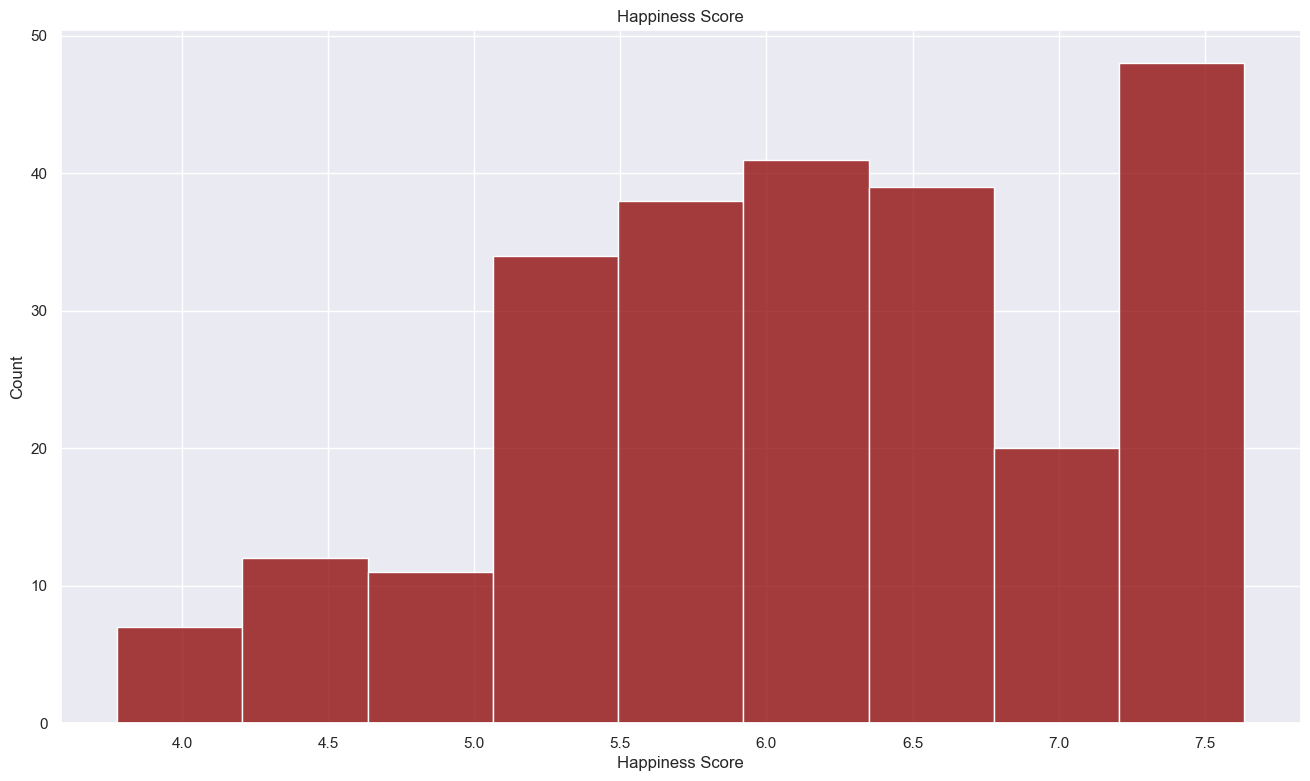

In [8]:
sns.set(rc={'figure.figsize':(16,9)})
sns.histplot(x="Happiness Score", data=merged2, bins = 'auto', color = 'darkred').set(title='Happiness Score')

## The Happiest & Least Happy Countries

If the alternative hypothesis is true, then the happiest countries should have a higher Big Mac Index than the least happy countries. Looking at the top 5 happiest and least happy countries we can see that this holds true with the exception of Sri-Lanka. Sri-Lanka is the 3rd least happy country but has a positive Big Mac Index. Denmark also has a Big Mac Index close to zero but is the happiest country in our sample. These exceptions suggest that there may be a weak correlation between the Big Mac Index and Happiness Score.

In [9]:
# Group by country and calculate mean happiness score
happiness_by_country = merged2.groupby('Country_1').mean()

# Looking at the happiest countries on average
happiness_by_country.sort_values(ascending = False, by = 'Happiness Score').head()

C:\Users\kylep\AppData\Local\Temp\ipykernel_23904\2585175055.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  happiness_by_country = merged2.groupby('Country_1').mean()


,BigMacIndex(USD),Happiness Score
Country_1,,
Denmark,0.053869,7.569429
Switzerland,0.502316,7.520000
Norway,0.307080,7.494571
Sweden,0.363260,7.334714
New Zealand,0.058720,7.291714


In [10]:
# Looking at the least happy countries on average
happiness_by_country.sort_values(ascending = True, by = 'Happiness Score').head()

,BigMacIndex(USD),Happiness Score
Country_1,,
India,-0.215606,4.155000
Jordan,-0.098945,4.273500
Sri Lanka,0.149085,4.343500
Egypt,-0.289744,4.349571
South Africa,-0.342597,4.789429


# Quadrant Analysis

With examples like Sri Lanka and Denmark, creating a scatterplot can give us a view at the entire dataset and help us identify any other extreme values.

* Russia has the lowest Big Mac index but a happiness score that is slightly below average. Russia's low Big Mac Index and moderate Happiness score can be attributed to the complex interplay of economic, political, social, and cultural factors. While the Big Mac Index gives an idea of the cost of living and currency valuation, it does not encompass the broader aspects that contribute to a nation's overall well-being and happiness.

* Switzerland is an outlier with a high Big Mac Index and a high happiness score, highlighting an extreme case of an overvalued currency it's correlation with happiness.

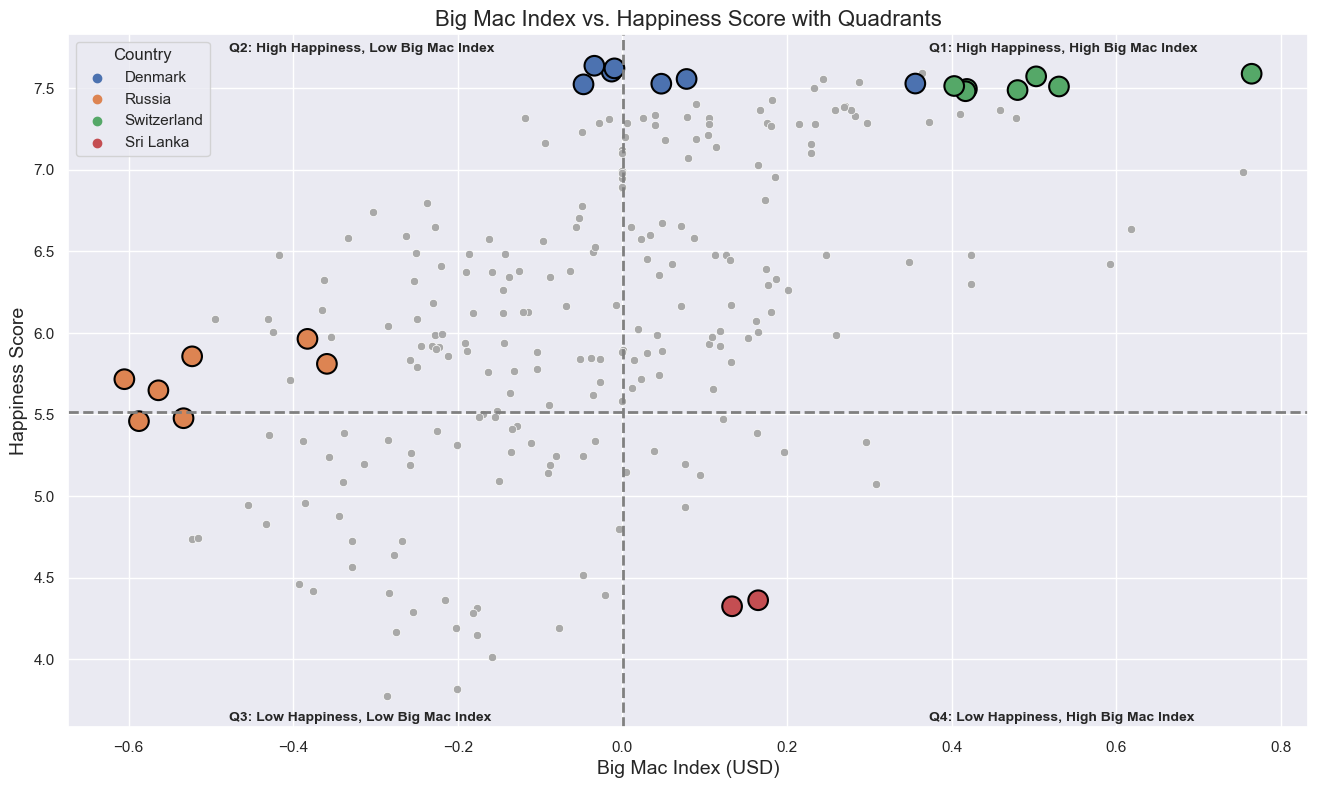

In [11]:
# Create a scatterplot of Big Mac Index vs Happiness Score with highlighted outliers
outliers = merged2[merged2['Country_1'].isin(["Denmark", "Sri Lanka", 'Russia', 'Switzerland'])]
sns.set(rc={'figure.figsize':(16,9)})
fig, ax = plt.subplots()
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", color = 'darkgrey', data=merged2)
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", hue='Country_1',data=outliers, marker='o', s=200, edgecolor='black', linewidth=1.5, ax=ax)

legend = ax.legend()
legend.set_title("Country")


ax.axhline(y=merged2['Happiness Score'].median()-0.61, color='gray', linestyle='--', lw=2)
ax.axvline(x=merged2['BigMacIndex(USD)'].median()+0.028, color='gray', linestyle='--', lw=2)
ax.text(merged2['BigMacIndex(USD)'].median()+0.4, merged2['Happiness Score'].median()+1.6, 'Q1: High Happiness, High Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()-0.45, merged2['Happiness Score'].median()+1.6, 'Q2: High Happiness, Low Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()-0.45, merged2['Happiness Score'].median()-2.5, 'Q3: Low Happiness, Low Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()+0.4, merged2['Happiness Score'].median()-2.5, 'Q4: Low Happiness, High Big Mac Index', fontsize=10, fontweight='bold')


plt.title('Big Mac Index vs. Happiness Score with Quadrants', fontsize=16)
plt.xlabel('Big Mac Index (USD)', fontsize=14)
plt.ylabel('Happiness Score', fontsize=14)

plt.show()

## Testing for correlation
Looking at this regression plot, we can see a moderate positive, linear trend. 

<Axes: xlabel='BigMacIndex(USD)', ylabel='Happiness Score'>

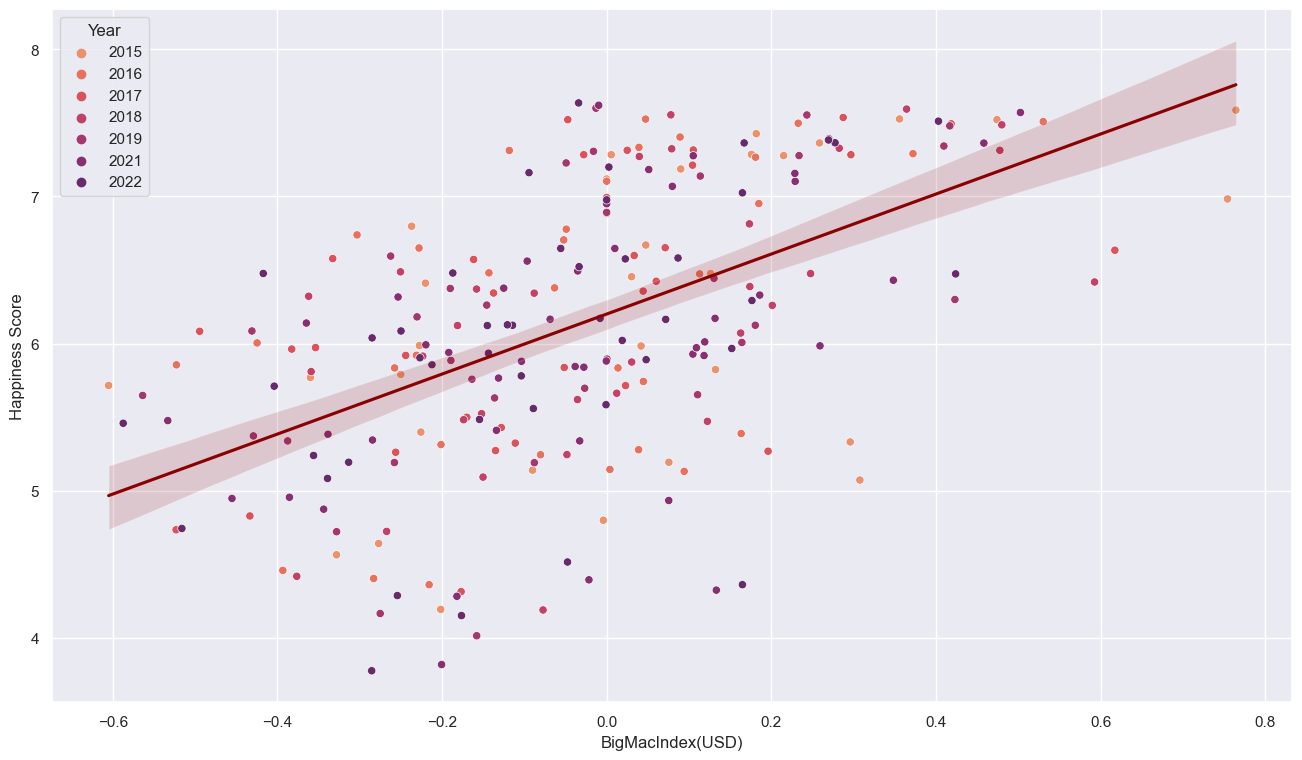

In [12]:
# above table visualized
sns.set(rc={'figure.figsize':(16,9)})
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", hue = 'Year' ,palette="flare", data= merged2)
sns.regplot(x="BigMacIndex(USD)", y="Happiness Score", scatter = False,color = 'darkred', data= merged2)

In [13]:
# find r coeificient and p value
r, p = pearsonr(merged2['BigMacIndex(USD)'], merged2['Happiness Score'])

print(r,p)

0.5429185430249959 1.4428401049527233e-20


The Pearson's R test indicates with a very low p value (nearly zero) that there is a moderately strong correlation (0.54) between the Big Mac Index and Happiness.

# Conclusion

After conducting both visual and statistical analyses, we have rejected the null hypothesis and can confidently conclude that a moderate positive linear relationship exists between a country's Big Mac Index and its overall level of happiness. This is because countries with undervalued currencies (as indicated by a low Big Mac Index) may struggle to afford imported goods, resulting in higher costs for necessities and possibly contributing to lower levels of happiness. Conversely, countries with overvalued currencies (as indicated by a high Big Mac Index) are likely to experience greater affordability of imported goods, leading to higher levels of happiness.